In [92]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt

#scikit-learn preprocessing libraries
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler,MinMaxScaler

from sklearn.metrics import (precision_score,
                             plot_precision_recall_curve,
                             accuracy_score,
                             confusion_matrix,
                             plot_confusion_matrix,
                             precision_recall_fscore_support)

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# import xgboostpi
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer,make_column_selector,make_column_transformer
from sklearn.pipeline import make_pipeline,Pipeline

from sklearn import set_config
set_config(display = 'diagram')

from sklearn.preprocessing import FunctionTransformer
from sklearn.tree import plot_tree


#clear warnings
import warnings
warnings.filterwarnings('ignore')

In [56]:
df = pd.read_csv("cleaned_data_v2.xlsx")
df.head()

,Unnamed: 0,schtype,gender,circuit,c_record,mock,age_category,ict
0,0,PRIVATE,M,SALTPOND B,38,85.0,regular,Pass
1,1,PRIVATE,F,SALTPOND B,36,67.0,regular,Pass
2,2,PUBLIC,M,MANKESSIM A,38,67.0,high school,Pass
3,3,PRIVATE,M,SALTPOND B,38,83.0,regular,Pass
4,4,PUBLIC,M,MDOMINASE,37,65.0,tertiary,Pass


## Data Preprocessing

In [57]:
df = df.drop(columns = df.iloc[:,[0]].columns) #drop Unnamed 0
df.head()

,schtype,gender,circuit,c_record,mock,age_category,ict
0,PRIVATE,M,SALTPOND B,38,85.0,regular,Pass
1,PRIVATE,F,SALTPOND B,36,67.0,regular,Pass
2,PUBLIC,M,MANKESSIM A,38,67.0,high school,Pass
3,PRIVATE,M,SALTPOND B,38,83.0,regular,Pass
4,PUBLIC,M,MDOMINASE,37,65.0,tertiary,Pass


In [58]:
df['circuit'].value_counts()

MANKESSIM A    645
MANKESSIM B    501
SALTPOND A     462
ANOMABO A      375
MDOMINASE      333
SALTPOND B     328
ANOMABO B      251
YAMORANSA      248
Name: circuit, dtype: int64

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3143 entries, 0 to 3142
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   schtype       3143 non-null   object 
 1   gender        3143 non-null   object 
 2   circuit       3143 non-null   object 
 3   c_record      3143 non-null   int64  
 4   mock          3143 non-null   float64
 5   age_category  3143 non-null   object 
 6   ict           3143 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 172.0+ KB


In [60]:
X  = df.iloc[:,df.columns!='ict']
y= df.iloc[:,df.columns=='ict'] # just fancy :)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.3,stratify=y,random_state = 111) #split data into training and test set

In [62]:
X_test.size/X.size

0.3000318167356029

In [63]:
print("% of traininig features : {}{}".format( round( (X_train.size/X.size)*100, 2), "%") )
print("% of testing features   : {}{}".format( round( (X_test.size/X.size)*100, 2), "%" ) )

% of traininig features : 70.0%
% of testing features   : 30.0%


In [64]:
circuit_order = list(df.circuit.value_counts().index) #get levels from circuit column sorted by mode
circuit_order

['MANKESSIM A',
 'MANKESSIM B',
 'SALTPOND A',
 'ANOMABO A',
 'MDOMINASE',
 'SALTPOND B',
 'ANOMABO B',
 'YAMORANSA']

In [65]:
X_train.head()

,schtype,gender,circuit,c_record,mock,age_category
2602,PUBLIC,F,MANKESSIM B,33,26.0,tertiary
844,PRIVATE,F,MANKESSIM B,35,35.0,tertiary
1009,PUBLIC,F,MANKESSIM B,35,35.0,regular
2106,PUBLIC,M,MANKESSIM A,35,33.0,regular
357,PUBLIC,F,MANKESSIM B,38,57.0,regular


In [66]:
y_train.head()

,ict
2602,Pass
844,Fail
1009,Pass
2106,Pass
357,Pass


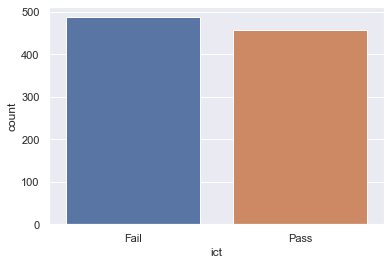

In [67]:
sns.countplot(x = 'ict',data = y_test);

In [68]:
y_train.value_counts()

ict 
Fail    1135
Pass    1065
dtype: int64

In [69]:
#construct column transformers
ct = ColumnTransformer([("onehot",
                         OneHotEncoder(categories = [["M","F"],['regular','high school','tertiary'],],drop = np.array(["F",'regular',]),sparse = False),
                         ['gender','age_category']),
                        
                        ("ordinal",
                         OrdinalEncoder(categories=[['PUBLIC','PRIVATE'],circuit_order],handle_unknown='error'),
                         ["schtype","circuit"])],
                       remainder = 'passthrough')

#Scaler Transformer
#scaler = ColumnTransformer([('scaler',StandardScaler(),['c_record','mock'])]) #using Standard Scaler
scaler = ColumnTransformer([('scaler',MinMaxScaler(),[-2,-1])],remainder = 'passthrough') #using Normalization or MinMaxScaler


# One Hot Encoding
ohe = OneHotEncoder(categories = [['PRIVATE','PUBLIC'],["M","F"],circuit_order],
                   drop = np.array(["PRIVATE","F","YAMORANSA"]),sparse = False)


# Ordinal Encoding
oe = OrdinalEncoder(categories=[['PRIVATE','PUBLIC'],["M","F"],circuit_order],handle_unknown='error')


ct2 = ColumnTransformer([("encoder",ohe,make_column_selector(dtype_include = pd.CategoricalDtype))],remainder = 'passthrough')


ct3 = ColumnTransformer([("encoder",oe,make_column_selector(dtype_include = "O"))],remainder = 'passthrough')

# Random  Forest Classifier

In [212]:
rf = RandomForestClassifier(500,criterion = 'entropy',random_state = 111) #initial random forest model

In [213]:
rf_pipeline = Pipeline([("encoder",ct),('scaler',scaler),("model",rf)]) #model pipeline with feature scaling
rf_pipeline2 = Pipeline([("transformer",ct),("model",rf)]) #model pipeline without feature scaling

In [214]:
rf_pipeline.fit(X_train,y_train)

Pipeline(steps=[('encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(categories=[['M',
                                                                             'F'],
                                                                            ['regular',
                                                                             'high '
                                                                             'school',
                                                                             'tertiary']],
                                                                drop=array(['F', 'regular'], dtype='<U7'),
                                                                sparse=False),
                                                  ['gender', 'age_category']),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['PUBLIC',
                                                                              'PRIVATE'],
                                                                             ['MANKESSIM '
                                                                              'A',
                                                                              'MANKESSIM '
                                                                              'B',
                                                                              'SALTPOND '
                                                                              'A',
                                                                              'ANOMABO '
                                                                              'A',
                                                                              'MDOMINASE',
                                                                              'SALTPOND '
                                                                              'B',
                                                                              'ANOMABO '
                                                                              'B',
                                                                              'YAMORANSA']]),
                                                  ['schtype', 'circuit'])])),
                ('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', MinMaxScaler(),
                                                  [-2, -1])])),
                ('model',
                 RandomForestClassifier(criterion='entropy', n_estimators=500,
                                        random_state=111))])

In [215]:
scaler_features = rf_pipeline['scaler'].get_feature_names_out()
scaler_features

array(['scaler__x5', 'scaler__x6', 'remainder__x0', 'remainder__x1',
       'remainder__x2', 'remainder__x3', 'remainder__x4'], dtype=object)

In [216]:
rf_pipeline.score(X_test,y_test)

0.8144220572640509

In [217]:
rf_pipeline.score(X_train,y_train) #training score|

0.9563636363636364

In [218]:
feature_importances = rf_pipeline['model'].feature_importances_
print(feature_importances)

[0.20343704 0.52036852 0.02872859 0.01485304 0.02646308 0.04220595
 0.16394378]


### Demystifying the Pipeline

In [203]:
rf_pipeline['encoder']

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehot',
                                 OneHotEncoder(categories=[['M', 'F'],
                                                           ['regular',
                                                            'high school',
                                                            'tertiary']],
                                               drop=array(['F', 'regular'], dtype='<U7'),
                                               sparse=False),
                                 ['gender', 'age_category']),
                                ('ordinal',
                                 OrdinalEncoder(categories=[['PUBLIC',
                                                             'PRIVATE'],
                                                            ['MANKESSIM A',
                                                             'MANKESSIM B',
                                                             'SALTPOND A',
                                                             'ANOMABO A',
                                                             'MDOMINASE',
                                                             'SALTPOND B',
                                                             'ANOMABO B',
                                                             'YAMORANSA']]),
                                 ['schtype', 'circuit'])])

In [204]:
#output from transformer preprocessor (OneHot and Ordinal Encoding) inside the pipeline
encoder_process = pd.DataFrame(rf_pipeline['encoder'].transform(X_train), columns=rf_pipeline['encoder'].get_feature_names_out())
encoder_process.head()

,onehot__gender_M,onehot__age_category_high school,onehot__age_category_tertiary,ordinal__schtype,ordinal__circuit,remainder__c_record,remainder__mock
0,0.0,0.0,1.0,0.0,1.0,33.0,26.0
1,0.0,0.0,1.0,1.0,1.0,35.0,35.0
2,0.0,0.0,0.0,0.0,1.0,35.0,35.0
3,1.0,0.0,0.0,0.0,0.0,35.0,33.0
4,0.0,0.0,0.0,0.0,1.0,38.0,57.0


In [205]:
#extracting actual feature names from the pipeline

encoder_output_features = [(i.split('__')[1]) for i in rf_pipeline['encoder'].get_feature_names_out()]

print("Output features from the Encoders :",encoder_output_features,"\n\n")

#get the scaler's output features

#As specified in the transformer, the c_record and mock (in that order) will be handled first before the normal order from the encoder process follows

#extract c_record and mock from encoders output features and append them in front of the list of features
c_record_and_mock = [encoder_output_features.pop(i) for i in [-2,-1]]

features = [*c_record_and_mock,*encoder_output_features]

print("Output features from the Scaler:",features)
#the scaler's output is what the model sees

Output features from the Encoders : ['gender_M', 'age_category_high school', 'age_category_tertiary', 'schtype', 'circuit', 'c_record', 'mock'] 


Output features from the Scaler: ['c_record', 'mock', 'gender_M', 'age_category_high school', 'age_category_tertiary', 'schtype', 'circuit']


In [206]:
#output of the encoder is then fed to the Scaler
pd.DataFrame(rf_pipeline['scaler'].transform(encoder_process.values),columns = features).head()

,c_record,mock,gender_M,age_category_high school,age_category_tertiary,schtype,circuit
0,0.250,0.298851,0.0,0.0,1.0,0.0,1.0
1,0.500,0.402299,0.0,0.0,1.0,1.0,1.0
2,0.500,0.402299,0.0,0.0,0.0,0.0,1.0
3,0.500,0.379310,1.0,0.0,0.0,0.0,0.0
4,0.875,0.655172,0.0,0.0,0.0,0.0,1.0


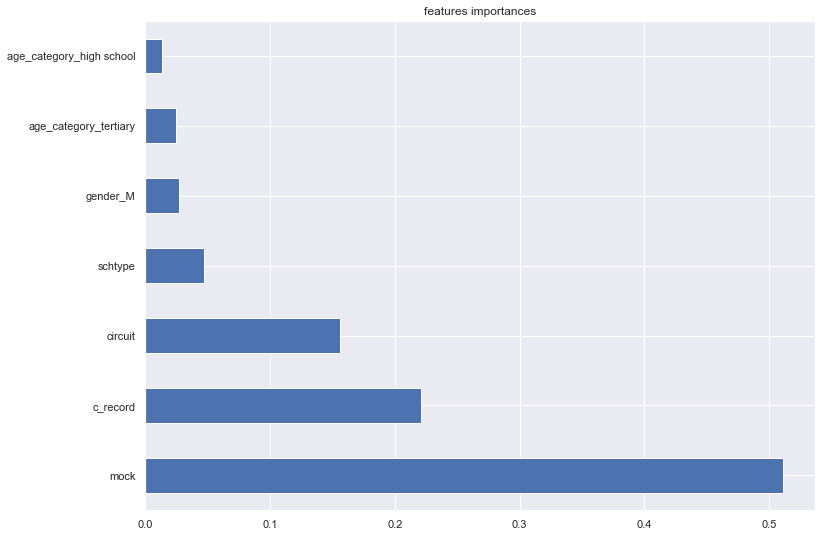

In [207]:
plt.figure(figsize = (12,9))
feat_importances = pd.Series(feature_importances, index = features)
feat_importances.nlargest(15).plot(kind='barh')
plt.title("features importances")
plt.show()

In [208]:
rf_pipeline.get_params().keys() #available parameters for tuning

dict_keys(['memory', 'steps', 'verbose', 'encoder', 'scaler', 'model', 'encoder__n_jobs', 'encoder__remainder', 'encoder__sparse_threshold', 'encoder__transformer_weights', 'encoder__transformers', 'encoder__verbose', 'encoder__verbose_feature_names_out', 'encoder__onehot', 'encoder__ordinal', 'encoder__onehot__categories', 'encoder__onehot__drop', 'encoder__onehot__dtype', 'encoder__onehot__handle_unknown', 'encoder__onehot__max_categories', 'encoder__onehot__min_frequency', 'encoder__onehot__sparse', 'encoder__ordinal__categories', 'encoder__ordinal__dtype', 'encoder__ordinal__encoded_missing_value', 'encoder__ordinal__handle_unknown', 'encoder__ordinal__unknown_value', 'scaler__n_jobs', 'scaler__remainder', 'scaler__sparse_threshold', 'scaler__transformer_weights', 'scaler__transformers', 'scaler__verbose', 'scaler__verbose_feature_names_out', 'scaler__scaler', 'scaler__scaler__clip', 'scaler__scaler__copy', 'scaler__scaler__feature_range', 'model__bootstrap', 'model__ccp_alpha', 'm

### Model Evaluation

In [195]:
y_predict = rf_pipeline.predict(X_test)

In [171]:
confusion_matrix(y_test,y_predict)

array([[389,  98],
       [ 79, 377]], dtype=int64)

In [172]:
from sklearn.metrics import ConfusionMatrixDisplay

<Figure size 648x576 with 0 Axes>

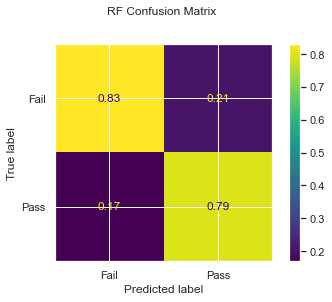

In [173]:
plt.figure(figsize = (9,8));
ConfusionMatrixDisplay.from_estimator(estimator = rf_pipeline,X = X_test,y = y_test,normalize = 'pred'); #normalize - True) #normalized by true labels
plt.title('RF Confusion Matrix \n\n');

False Positives = 20%
True Positives = 80%

False Negatives = 17%
True Negatives = 83%

<Figure size 648x576 with 0 Axes>

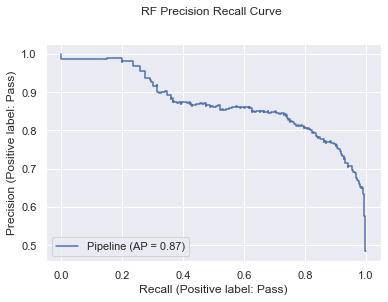

In [174]:
#Precision Recall Curve

plt.figure(figsize = (9,8));
plot_precision_recall_curve(estimator = rf_pipeline,X = X_test,y = y_test);
plt.title("RF Precision Recall Curve \n\n");

In [175]:
(precision,recall, Fmeasure,support) = precision_recall_fscore_support(y_test,y_predict)

In [176]:
rf_metrics = pd.DataFrame(
    precision_recall_fscore_support(y_test,y_predict),
    columns = ['Fail','Pass'],
    index = ['precision',
             'recall',
             'F-measure',
             'support']
)

rf_metrics

,Fail,Pass
precision,0.831197,0.793684
recall,0.798768,0.826754
F-measure,0.814660,0.809882
support,487.000000,456.000000


### Decion Tree Classifier

In [177]:
dt = Pipeline([("transformer",ct),("model",DecisionTreeClassifier(max_depth= 5,criterion = 'entropy',random_state = 42))])

In [178]:
dt.fit(X_train,y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(categories=[['M',
                                                                             'F'],
                                                                            ['regular',
                                                                             'high '
                                                                             'school',
                                                                             'tertiary']],
                                                                drop=array(['F', 'regular'], dtype='<U7'),
                                                                sparse=False),
                                                  ['gender', 'age_category']),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['PUBLIC',
                                                                              'PRIVATE'],
                                                                             ['MANKESSIM '
                                                                              'A',
                                                                              'MANKESSIM '
                                                                              'B',
                                                                              'SALTPOND '
                                                                              'A',
                                                                              'ANOMABO '
                                                                              'A',
                                                                              'MDOMINASE',
                                                                              'SALTPOND '
                                                                              'B',
                                                                              'ANOMABO '
                                                                              'B',
                                                                              'YAMORANSA']]),
                                                  ['schtype', 'circuit'])])),
                ('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=5,
                                        random_state=42))])

In [179]:
dt.score(X_train,y_train)

0.8327272727272728

In [180]:
dt.score(X_test,y_test)

0.8229056203605515

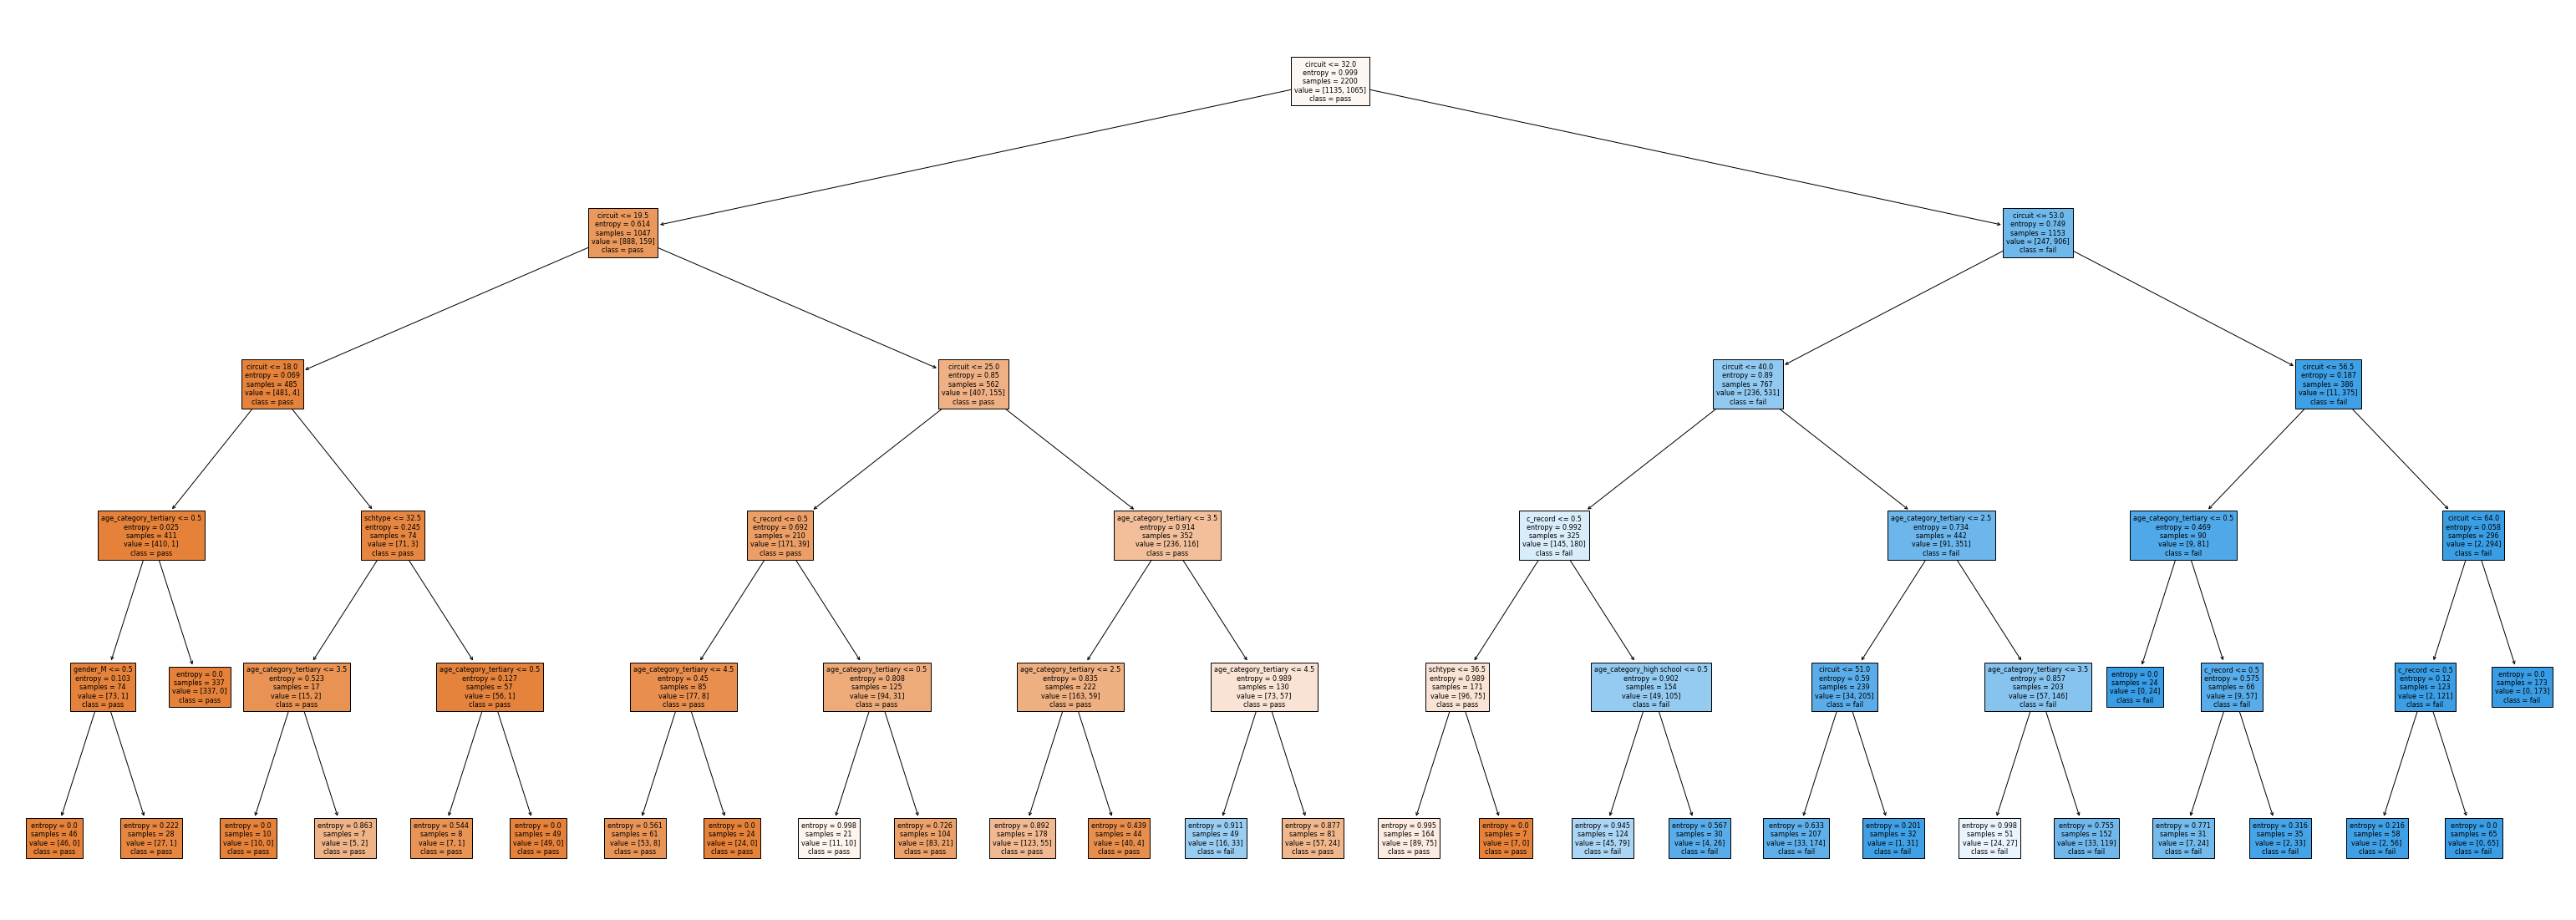

In [50]:
plt.figure(figsize=(55,20));
plot_tree(dt['model'],filled = True,fontsize= 8,class_names = ['pass','fail'],feature_names = features); #feature_names = ["gender","high school age","tertiary age","schtype","circuit"]

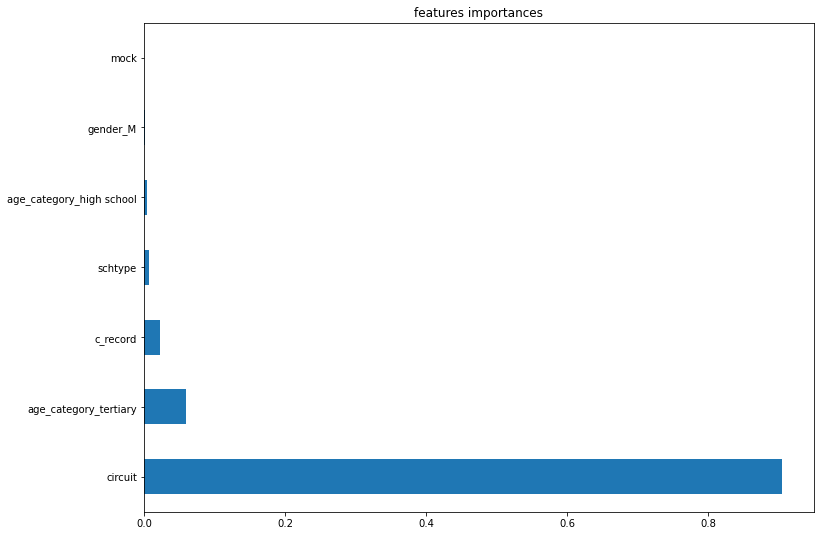

In [51]:
plt.figure(figsize = (12,9))
feat_importances = pd.Series(dt['model'].feature_importances_, index = features)
feat_importances.nlargest(15).plot(kind='barh')
plt.title("features importances")
plt.show()

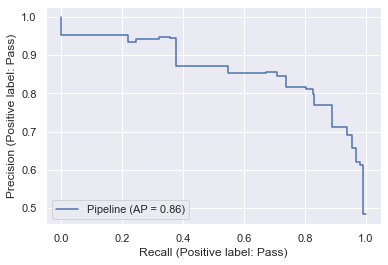

In [97]:
plot_precision_recall_curve(estimator = dt,X = X_test,y = y_test);

<h1> Support Vector Machines </h1>

In [136]:
from sklearn.svm import SVC
svc = SVC(kernel = 'linear')

In [137]:
svc_pipeline = Pipeline([("transformer",ct),("model",svc)])
svc_pipeline

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(categories=[['M',
                                                                             'F'],
                                                                            ['regular',
                                                                             'high '
                                                                             'school',
                                                                             'tertiary']],
                                                                drop=array(['F', 'regular'], dtype='<U7'),
                                                                sparse=False),
                                                  ['gender', 'age_category']),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['PUBLIC',
                                                                              'PRIVATE'],
                                                                             ['MANKESSIM '
                                                                              'A',
                                                                              'MANKESSIM '
                                                                              'B',
                                                                              'SALTPOND '
                                                                              'A',
                                                                              'ANOMABO '
                                                                              'A',
                                                                              'MDOMINASE',
                                                                              'SALTPOND '
                                                                              'B',
                                                                              'ANOMABO '
                                                                              'B',
                                                                              'YAMORANSA']]),
                                                  ['schtype', 'circuit'])])),
                ('model', SVC(kernel='linear'))])

In [138]:
svc_pipeline.fit(X_train,y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(categories=[['M',
                                                                             'F'],
                                                                            ['regular',
                                                                             'high '
                                                                             'school',
                                                                             'tertiary']],
                                                                drop=array(['F', 'regular'], dtype='<U7'),
                                                                sparse=False),
                                                  ['gender', 'age_category']),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['PUBLIC',
                                                                              'PRIVATE'],
                                                                             ['MANKESSIM '
                                                                              'A',
                                                                              'MANKESSIM '
                                                                              'B',
                                                                              'SALTPOND '
                                                                              'A',
                                                                              'ANOMABO '
                                                                              'A',
                                                                              'MDOMINASE',
                                                                              'SALTPOND '
                                                                              'B',
                                                                              'ANOMABO '
                                                                              'B',
                                                                              'YAMORANSA']]),
                                                  ['schtype', 'circuit'])])),
                ('model', SVC(kernel='linear'))])

In [139]:
svc_pipeline.score(X_test,y_test)

0.8144220572640509

In [140]:
svc_pipeline.score(X_train,y_train)

0.8259090909090909

# Adaptive Boosting - Adaboost

In [150]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

In [151]:
adaboost = AdaBoostClassifier(base_estimator = LogisticRegression(),n_estimators = 400,algorithm = 'SAMME')
adaboost = Pipeline([("transformer",ct),('model',adaboost)])

In [152]:
adaboost.fit(X_train,y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(categories=[['M',
                                                                             'F'],
                                                                            ['regular',
                                                                             'high '
                                                                             'school',
                                                                             'tertiary']],
                                                                drop=array(['F', 'regular'], dtype='<U7'),
                                                                sparse=False),
                                                  ['gender', 'age_category']),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['PUBLIC',
                                                                              'PRIVATE'],
                                                                             ['MANKESSIM '
                                                                              'A',
                                                                              'MANKESSIM '
                                                                              'B',
                                                                              'SALTPOND '
                                                                              'A',
                                                                              'ANOMABO '
                                                                              'A',
                                                                              'MDOMINASE',
                                                                              'SALTPOND '
                                                                              'B',
                                                                              'ANOMABO '
                                                                              'B',
                                                                              'YAMORANSA']]),
                                                  ['schtype', 'circuit'])])),
                ('model',
                 AdaBoostClassifier(algorithm='SAMME',
                                    base_estimator=LogisticRegression(),
                                    n_estimators=400))])

In [153]:
adaboost.score(X_test,y_test)

0.8027571580063627

In [154]:
adaboost.score(X_train,y_train)

0.8109090909090909

In [ ]:
LogisticRegression()

In [8]:
iphone = "https://tonaton.com/c_mobile-phones?query=iphone&page=2"
iphone.split("&")[-1].split("=")[-1]

'2'